In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from ldg.pickle import pickle_read
import pandas as pd
import re
import gspread

gc = gspread.oauth()
sh = gc.open("WSB results")
bucket1 = sh.get_worksheet(0)
bucket2 = sh.get_worksheet(1)
bucket3 = sh.get_worksheet(2)
bucket4 = sh.get_worksheet(3)

In [4]:
def read_row(l):
    return {
        "model": l[1],
        "insts": int(l[3]),
        "precision": float(l[4])
    }

def read_bucket(bucket):
    H = (2 + 6*7)
    onto_pts = []
    pdep_pts = []
    vals = bucket.get_all_values()
    for i in range(1,1+H):
        onto_pts.append(read_row(vals[i]))
    for i in range(1+H, 1+2*H):
        pdep_pts.append(read_row(vals[i]))
    return onto_pts, pdep_pts

# low freq, low prvl
onto_b1, pdep_b1 = read_bucket(bucket1)
# low freq, all prvl
onto_b2, pdep_b2 = read_bucket(bucket2)
# high freq, low prvl
onto_b3, pdep_b3 = read_bucket(bucket3)
# high freq, all prvl
onto_b4, pdep_b4 = read_bucket(bucket4)
onto_b4[0]

{'model': 'random baseline', 'insts': 0, 'precision': 0.7608325726}

In [58]:
def vstack(*xs, evt=""):
    s = r"\begin{tabular}{@{}c@{}}"
    for i, x in enumerate(xs):
        s += "{"f"{evt} " + x + "}"
        if i != len(xs) - 1:
            s += r" \\ "
    s += r"\end{tabular}"
    return s

def get(xs, model=None):
    for x in xs:
        if x['model'] == model:
            return x
    return None

MODEL_NAMES = ['bert-base-cased', 'distilbert-base-cased', 'roberta-base', 'distilroberta-base', 'albert-base-v2', 'xlnet-base-cased', 'gpt2']

def latex_table(b1, b2, b3, b4, ft=False):
    s = r"\begin{tabular}{c|cccc}""\n"
    s += r"& \multicolumn{4}{c}{{\small MAP at 50}} \\""\n"
    
    s += r"{\small Model} & "
    s += vstack(r"$\ell<500$", r"$r<0.25$", evt=r"\small")
    s += " & "
    s += vstack(r"$\ell<500$", r"$r \geq 0.25$", evt=r"\small")
    s += " & "
    s += vstack(r"$\ell>500$", r"$r<0.25$", evt=r"\small")
    s += " & "
    s += vstack(r"$\ell>500$", r"$ r \geq 0.25$", evt=r"\small")
    s += r" \\\hline""\n"
    
    # Baseline
    s += "{\\small Baseline} & "
    for i, b in enumerate([b1, b2, b3, b4]):
        s += r"{\small "
        s += "{:.2f}".format(get(b, model='random baseline')['precision'] * 100)
        s += "}"
        if i == 3:
            s += r" \\ ""\n"
        else:
            s += " & "
            
    # Oracle
    s += "{\\small Oracle} & "
    for i, b in enumerate([b1, b2, b3, b4]):
        s += r"{\small "
        s += "{:.2f}".format(get(b, model='oracle')['precision'] * 100)
        s += "}"
        if i == 3:
            s += r" \\ ""\n"
        else:
            s += " & "    
            
    for name in MODEL_NAMES:
        s += f"{{\\small {name}}} & "
        for i, b in enumerate([b1, b2, b3, b4]):
            if not ft:
                pt = get([x for x in b if x['insts'] == 0], model=name)
            else:
                pt = sorted([x for x in b if x['model'] == name and x['insts'] != 0], key=lambda x: -x['precision'])
                pt = pt[0]
            s += r"{\small "
            s += "{:.2f}".format(pt['precision'] * 100)
            s += "}"
            if i == 3:
                s += r" \\ ""\n"
            else:
                s += " & "    
                    
    s += r"\end{tabular}""\n"
    print("        " + s.replace("\n", "\n        "))
    
latex_table(onto_b1, onto_b2, onto_b3, onto_b4)
print()
latex_table(pdep_b1, pdep_b2, pdep_b3, pdep_b4)
print()
latex_table(onto_b1, onto_b2, onto_b3, onto_b4, ft=True)
print()
latex_table(pdep_b1, pdep_b2, pdep_b3, pdep_b4, ft=True)
    

        \begin{tabular}{c|cccc}
        & \multicolumn{4}{c}{{\small MAP at 50}} \\
        {\small Model} & \begin{tabular}{@{}c@{}}{\small $\ell<500$} \\ {\small $r<0.25$}\end{tabular} & \begin{tabular}{@{}c@{}}{\small $\ell<500$} \\ {\small $r \geq 0.25$}\end{tabular} & \begin{tabular}{@{}c@{}}{\small $\ell>500$} \\ {\small $r<0.25$}\end{tabular} & \begin{tabular}{@{}c@{}}{\small $\ell>500$} \\ {\small $ r \geq 0.25$}\end{tabular} \\\hline
        {\small Baseline} & {\small 11.55} & {\small 62.41} & {\small 9.55} & {\small 76.08} \\ 
        {\small Oracle} & {\small 82.02} & {\small 93.89} & {\small 100.00} & {\small 100.00} \\ 
        {\small bert-base-cased} & {\small 41.60} & {\small 81.89} & {\small 48.48} & {\small 88.53} \\ 
        {\small distilbert-base-cased} & {\small 39.80} & {\small 81.32} & {\small 48.17} & {\small 88.50} \\ 
        {\small roberta-base} & {\small 32.87} & {\small 78.39} & {\small 45.16} & {\small 88.37} \\ 
        {\small distilroberta-base} & {\

In [18]:
import os
import copy
from bssp.common import paths
from bssp.common.config import Config


K = 50
K_RANGE = range(5,55,5)

cfg = Config(
    "ontonotes",
    embedding_model="bert-base-cased",
    override_weights_path=None,
    metric="cosine",
    top_n=50,
    query_n=1,
    bert_layers=[11],
    train_freq_buckets=[[5,500],[500,1000000000.]],
    prevalence_buckets=[[0.0,0.25],[0.25,1.0]]
)

def override_config(cfg, metric, model, query_n, bert_layers, override_weights_path):
    cfg2 = copy.copy(cfg)
    if metric is not None:
        cfg2.metric = metric
    if model:
        cfg2.embedding_model = model 
    if query_n:
        cfg2.query_n = query_n
    if bert_layers:
        cfg2.bert_layers = bert_layers
    if override_weights_path:
        cfg2.override_weights_path = override_weights_path
    return cfg2

def read_score(min_train_freq, max_train_freq, min_rarity, max_rarity, eval, metric=None, model=None, query_n=None, bert_layers=None, override_weights_path=None):
    cfg2 = override_config(cfg, metric=metric, model=model, query_n=query_n, bert_layers=bert_layers, override_weights_path=override_weights_path)
    filepath = paths.bucketed_metric_at_k_path(
        cfg2,
        min_train_freq=min_train_freq,
        max_train_freq=max_train_freq,
        min_rarity=min_rarity,
        max_rarity=max_rarity,
        ext=eval
    )
    if not os.path.isfile(filepath):
        print("WARNING: not found: ", filepath)
        return None
    return pickle_read(filepath)

def read_data(metric=None, model=None, query_n=None, bert_layers=None, override_weights_path=None):
    cfg2 = override_config(cfg, metric=metric, model=model, query_n=query_n, bert_layers=bert_layers, override_weights_path=override_weights_path)
    filepath = paths.predictions_tsv_path(cfg2)
    data = pd.read_csv(filepath, sep='\t')
    return data

cosine_data = read_data('cosine', bert_layers=[11])#, override_weights_path="models/bert-base-cased_250.pt")
cosine_data.keys()

Index(['sentence', 'label', 'lemma', 'label_freq_in_train', 'label_1',
       'label_2', 'label_3', 'label_4', 'label_5', 'label_6',
       ...
       'distance_41', 'distance_42', 'distance_43', 'distance_44',
       'distance_45', 'distance_46', 'distance_47', 'distance_48',
       'distance_49', 'distance_50'],
      dtype='object', length=204)

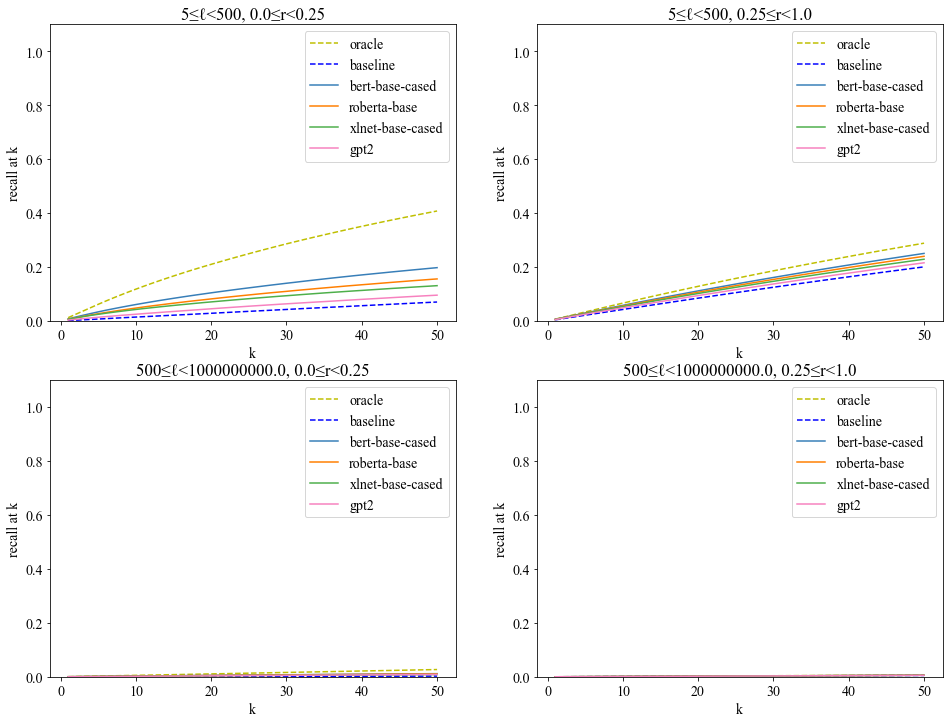

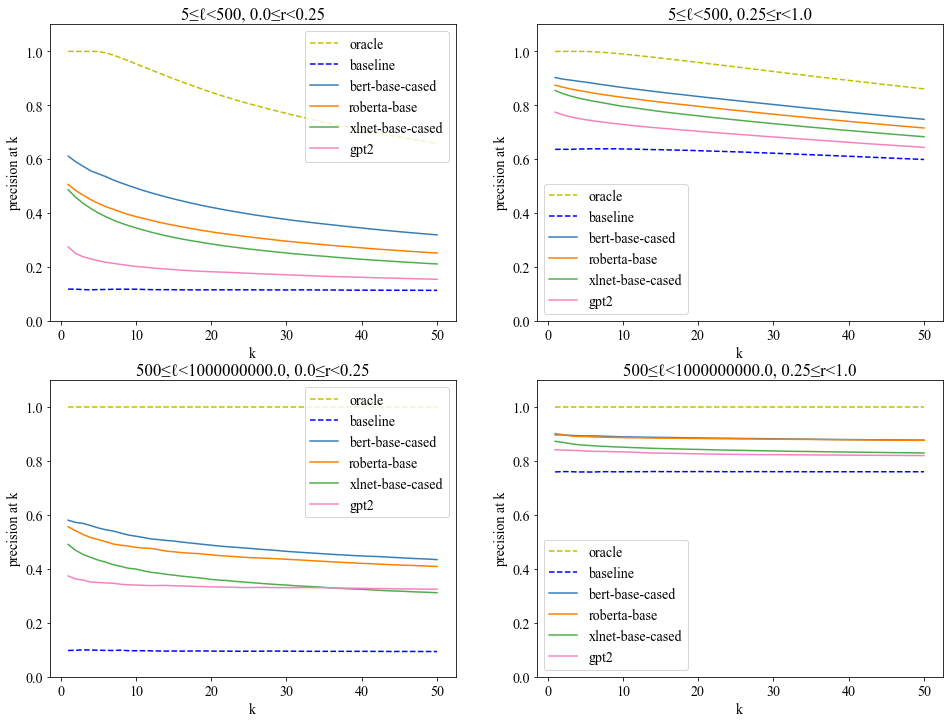

In [57]:
def xyzize(scores_dict, key='synset'):
    x, y, z = [], [], []
    for cutoff, p_at_k_dict in scores_dict.items():
        for k, scores in p_at_k_dict.items():
            if k > cutoff and False:
                continue
            x.append(cutoff)
            y.append(k)
            z.append(scores[key])
    return x, y, z
    
def plot_p_vs_k(p_at_k_dict, p_at_k_dict_2=None, key='synset'):
    plt.figure(figsize=(9,9))
    ax = plt.axes()
    ax.set_xlabel('k')
    ax.set_ylabel(f'{key} precision')
    ax.set_ylim(0, 1)
    
    k, scores = list(zip(*p_at_k_dict.items()))
    scores = [x[key] for x in scores]
    k = list(k)
    ax.scatter(x=k, y=scores, c=scores)
    if p_at_k_dict_2:
        k, scores = list(zip(*p_at_k_dict_2.items()))
        scores = [x[key] for x in scores]
        k = list(k)       
        ax.scatter(x=k, y=scores, c=scores, marker='x')
    plt.show()    
    
    
TEMPSTATE = 0
def plot_grid(configs, key='label', evals=['rec'], metric='cosine', query_n=1):
    global TEMPSTATE
    fig, axs = plt.subplots(2,2,figsize=(16,12))
    #plt.subplots_adjust(hspace=1.0, wspace=0.5)
    #fig.suptitle("Microaveraged " + ("Recall" if evals[0]=='rec' 
    #              else "Oracle Recall" if evals[0]=='orec'
    #              else "Truncated Recall" if evals[0]=='trec'
    #              else "Precision") + " at K")
    #plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 14

    
    i = 0
    for min_train_freq, max_train_freq in cfg.train_freq_buckets:
        for min_rarity, max_rarity in cfg.prevalence_buckets:
            ax = axs[i//2][i%2]
            i += 1
            lemmas = pickle_read(paths.bucketed_metric_at_k_path(
                cfg,
                min_train_freq=min_train_freq, 
                max_train_freq=max_train_freq, 
                min_rarity=min_rarity, 
                max_rarity=max_rarity, 
                ext='lemmas', 
            ))
            instance_count = pickle_read(paths.bucketed_metric_at_k_path(
                cfg,
                min_train_freq=min_train_freq, 
                max_train_freq=max_train_freq, 
                min_rarity=min_rarity, 
                max_rarity=max_rarity, 
                ext='count', 
            ))
            
            tstr = f'{min_train_freq}≤ℓ<{max_train_freq}, {min_rarity}≤r<{max_rarity}'
            ax.set_title(tstr)
            #print(tstr) 
            #print(lemmas)
            #ax.set_ylim(0.2, 0.8)
            ax.set_ylim(0, 1.1)
            ax.set_xlabel('k')
            ax.set_ylabel(('precision' if 'prec' in configs[0]['eval'] else 'recall') + " at k")
            for c in configs:
                metric_ = c.get('metric') or metric
                color_ = c.get('color') or 'pink'
                eval_ = c['eval']
                query_n_ = c.get('query_n') or query_n
                bert_layers_ = c.get('bert_layers') or None
                embedding_model_ = c.get('model') or cfg.embedding_model
                override_weights_path_ = c.get('override_weights_path', None)
            
                scores = read_score(
                    eval=eval_, 
                    min_train_freq=min_train_freq, 
                    max_train_freq=max_train_freq, 
                    min_rarity=min_rarity, 
                    max_rarity=max_rarity,
                    metric=metric_,
                    query_n=query_n_,
                    bert_layers=bert_layers_,
                    override_weights_path=override_weights_path_,
                    model=embedding_model_
                )
                if scores is None:
                    continue
                k, scores = list(zip(*scores.items()))
                scores = [x[key] for x in scores]
                k = list(k)
                #ax.scatter(x=k, y=scores, c=scores)
                label = 'oracle' if eval_[0] == 'o' else 'baseline' if metric_ == 'baseline' else embedding_model_
                ax.plot(k, scores, color_, label=label)
            ax.legend()
        
        
    if TEMPSTATE == 0:
        plt.savefig('/home/luke/tmp/recall.pdf')
        TEMPSTATE += 1
    else:
        plt.savefig('/home/luke/tmp/precision.pdf')
    #plt.show()
    
for i in range(2):
    s = ''
    if i == 1:
        s = 'p'
    plot_grid([
        # layers --------------------------------------------------------------------------------
        dict(metric='baseline', eval=f'o{s}rec', color='y--', bert_layers=[7]),
        dict(metric='baseline', eval=f'{s}rec', color='b--', bert_layers=[7]),
        
        # https://gist.github.com/thriveth/8560036
        dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[11], color='#377eb8', model="bert-base-cased"),
        dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[11], color='#ff7f00', model="roberta-base"),
        dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[11], color='#4daf4a', model="xlnet-base-cased"),
        dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[11], color='#f781bf', model="gpt2"),
        
        #dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[11], color='blue')#, override_weights_path="models/bert-base-cased_250.pt"),
        
        #dict(metric='cosine', eval=f'{s}rec', query_n=2, bert_layers=[7], color='green'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=3, bert_layers=[7], color='blue'),
        
        #dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[0], color='red'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[6], color='orange'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[10], color='green'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=5, bert_layers=[0], color='r--'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=5, bert_layers=[6], color='b--'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=5, bert_layers=[10], color='g--'),
        
        #dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[6],  color='r--'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[7],  color='y--'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[8],  color='g--'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[9],  color='b--'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[10], color='c--'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[11], color='v--'),
        
        #dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[6], color='red'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=3, bert_layers=[6], color='green'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=5, bert_layers=[6], color='blue'),
        
        #dict(metric='baseline', eval=f'o{s}rec', color='y--', query_category='nota'),
        #dict(metric='baseline', eval=f'{s}rec', color='m--', query_category='nota'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[6], color='r--', query_category='nota'),
        ##
        #dict(metric='baseline', eval=f'o{s}rec', color='g', query_category='non-nota'),
        #dict(metric='baseline', eval=f'{s}rec', color='c', query_category='non-nota'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=3, bert_layers=[6], color='b', query_category='non-nota'),
        
        #dict(metric='baseline', eval=f'o{s}rec', color='y--', query_category='non-nota', pos='all'),
        #dict(metric='baseline', eval=f'{s}rec', color='m--', query_category='non-nota', pos='all'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[6], color='r--', query_category='non-nota', pos='all'),
        ##
        #dict(metric='baseline', eval=f'o{s}rec', color='g', query_category='non-nota', pos='all'),
        #dict(metric='baseline', eval=f'{s}rec', color='c', query_category='non-nota', pos='all'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=3, bert_layers=[6], color='b', query_category='non-nota', pos='all'),
    ])


In [4]:
from bssp.common import paths


for query_n in [1]:
    print(query_n)
    for metric in ['cosine','euclidean','baseline']:
        for min_train_freq, max_train_freq in TRAIN_FREQ_BUCKETS:
            for min_rarity, max_rarity in PREVALENCE_BUCKETS:
                for bert_layer in range(12):
                    extra = {}
                    if metric != 'baseline':
                        extra['bert_layers'] = [bert_layer]
                    means = read_score(
                        query_category='non-nota',
                        pos='all',
                        eval='means', 
                        min_train_freq=min_train_freq, 
                        max_train_freq=max_train_freq, 
                        min_rarity=min_rarity, 
                        max_rarity=max_rarity,
                        metric=metric,
                        query_n=query_n,
                        **extra
                    )
                    if metric == 'baseline':
                        continue
                    #print(means)


1


NameError: name 'TRAIN_FREQ_BUCKETS' is not defined

In [ ]:
# data columns:
# sentence: original sentence
# label, lemma, synset, label_freq_in_train
# label_i
# synset_i
# lemma_i
# distance_i
list(cosine_data.keys())

def distance_correctness_corr(data, key='label'):
    
    plt.figure(figsize=(8,5))
    ax = plt.axes()
    ax.set_xlabel('k')
    ax.set_ylabel(f'distance correlated with correctness')
    
    df = data.copy()
    for i in range(1,K+1):
        df['correct'] = df[f'{key}_{i}'] == df[f'{key}']
        r = df[['correct', f'distance_{i}']].corr()['correct'][1]
        ax.scatter(i, r, color='blue')
    plt.show()
    

def distance_correctness_histogram(data, key='label'):
    df = data.copy()
    df['first_correct'] = df[f'{key}_1'] == df[f'{key}']
    df[['first_correct', 'distance_1']].pivot(columns='first_correct').distance_1.plot.hist(stacked=True, bins=50)
    plt.show()
    
    
distance_correctness_corr(cosine_data)
#distance_correctness_histogram(euclidean_data[euclidean_data.pos=='r'])
#distance_correctness_histogram(cosine_data)
    

In [ ]:
cosine_scores[5]